In [5]:
import os
import sys
import argparse

import imageio
import torch
from tqdm.notebook import tqdm
import torchvision.transforms as T
from PIL import Image

sys.path.append("../StyleCLIP_modular")
from style_clip import Imagine, create_text_path

In [6]:
parser = argparse.ArgumentParser()
parser.add_argument("--batch_size", default=32, type=int)
parser.add_argument("--gradient_accumulate_every", default=1, type=int)
parser.add_argument("--save_every", default=1, type=int)
parser.add_argument("--epochs", default=1, type=int)
parser.add_argument("--story_start_words", default=5, type=int)
parser.add_argument("--story_words_per_epoch", default=5, type=int)
parser.add_argument("--style", default="../stylegan2-ada-pytorch/VisionaryArt.pkl", type=str, choices=["faces (ffhq config-f)", "../stylegan2-ada-pytorch/VisionaryArt.pkl"])
parser.add_argument("--lr_schedule", default=0, type=int)
parser.add_argument("--start_image_steps", default=1000, type=int)
parser.add_argument("--iterations", default=100, type=int)
args = vars(parser.parse_args({}))

args["opt_all_layers"] = 1
args["lr_schedule"] = 1
args["noise_opt"] = 0
args["reg_noise"] = 0
args["seed"] = 1

args["model_type"] = "vqgan"
args["iterations"] = 200
args["save_every"] = 1
args["start_img_loss_weight"] = 0.0

args["lr"] = 0.1

#run(img="base_images/aicpa_logo_black.jpg", start_image_path="base_images/stance.jpg", args=args)
#run(img="base_images/aicpa_logo_black.jpg", start_image_path="base_images/earth.jpg", args=args)
#run(img="base_images/earth.jpg", start_image_path="base_images/aicpa_logo_black.jpg", args=args)

In [7]:
imagine = Imagine(
                save_progress=False,
                open_folder=False,
                save_video=False,
                **args
               )

setting seed: 1
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Number of parameters to optimize:  246016


In [8]:
args["start_image_steps"] = 500
args["sideX"] = 320
args["sideY"] = 320

path_dict = {"logo_black": "base_images/aicpa_logo_black.jpg",
        #"logo_purple": "base_images/aicpa_logo_purple.jpg",
        "earth": "base_images/earth.jpg",
        "stance": "base_images/stance.jpg",
        }
latent_dict = {}

for key in path_dict:
    print(key)
    path = path_dict[key]
    #args["start_image_path"] = path
    #imagine.reset()
    #imagine.start_image_path = path
    #img = imagine.prime_image()
    #latents = imagine.model.model.latents.detach().cpu()
    
    x = T.ToTensor()(Image.open(path)).unsqueeze(0).to(imagine.device).mul(2).sub(1)
    vqgan = imagine.model.model.model
    z, _, [_, _, indices] = vqgan.encode(x)
    latents = z
    
    latent_dict[key] = latents

logo_black
earth
stance


In [9]:
to_pil = T.ToPILImage()
def gen(imagine, latent):
    model = imagine.model.model
    model.latents = latent.to("cuda")
    image = model(return_loss=False)
    image = image.detach().cpu().squeeze(0)#.permute(1, 2, 0).clamp(0, 1) * 255
    #image = image.type(torch.uint8).clamp(0, 255)
    return to_pil(image)

In [10]:
print(latent_dict.keys())
prompt = "earth"
latent = latent_dict[prompt]
latent.shape

dict_keys(['logo_black', 'earth', 'stance'])


torch.Size([1, 256, 64, 63])

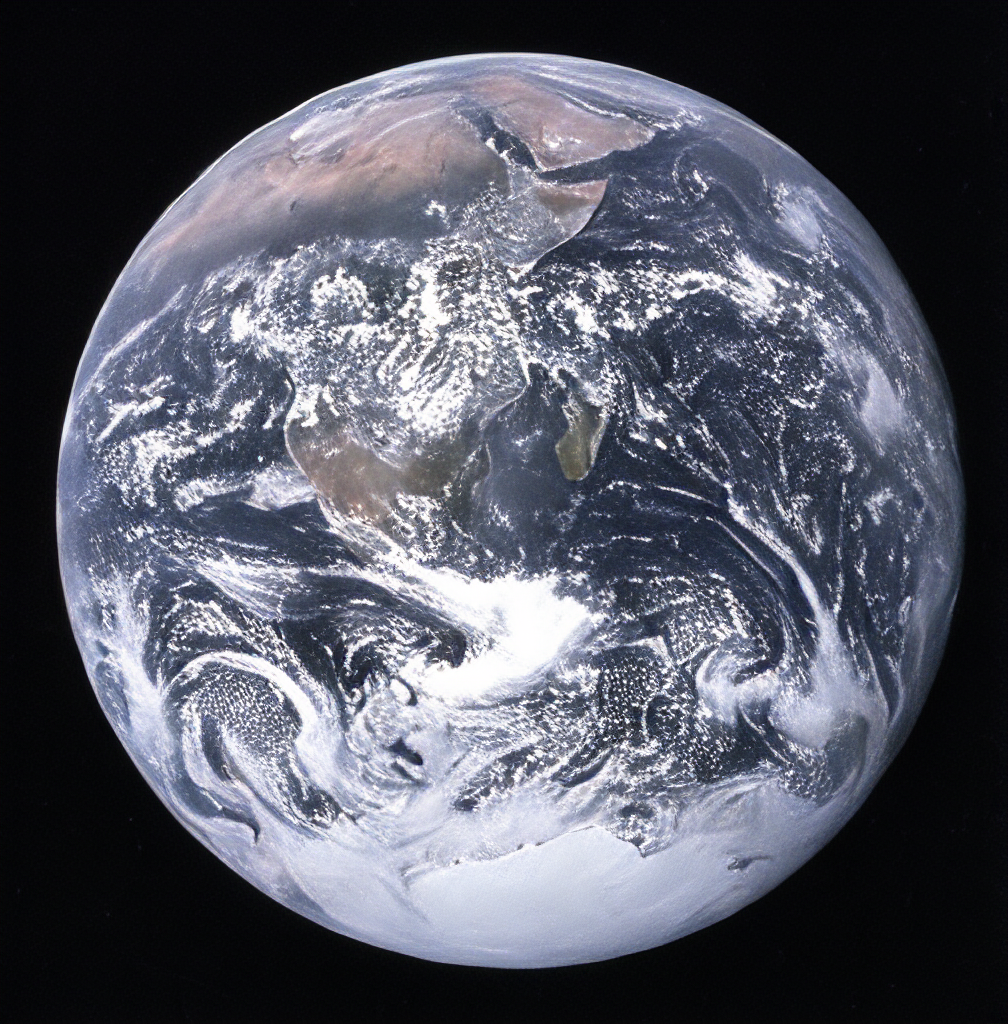

In [11]:
img = gen(imagine, latent)
img

In [8]:
import torchvision.transforms.functional as TF
#rot = lambda x: TF.rotate(x, 340, expand=False, fill = None)

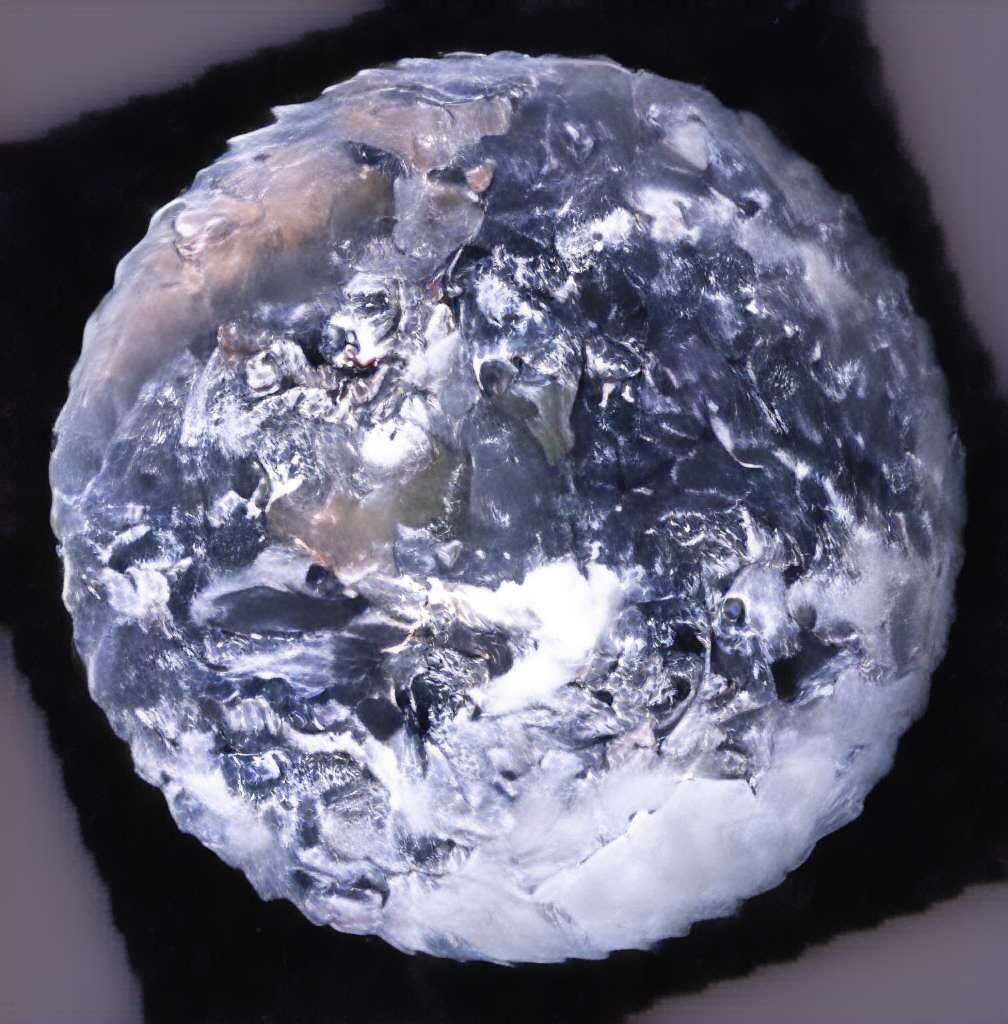

In [9]:
img = gen(imagine, TF.rotate(latent, 20, expand=False, fill = None))
img

In [79]:
angles = torch.arange(0, 360, 1).tolist()
# Generate arrays for rotation
#latent_transition = [TF.rotate(latent, angle, expand=0, fill=None) for angle in angles]
# rotate by rotating rotated image more and more
latent_transition = []
for i in range(360):
    l = latent_transition[-1] if len(latent_transition) > 0 else latent
    rot = TF.rotate(l, 10, expand=0, fill=None)
    latent_transition.append(rot)

In [80]:
# generate images from latents
images = []
for latent in tqdm(latent_transition):
    model = imagine.model.model
    model.latents = latent.to("cuda")
    image = model(return_loss=False)
    image = image.detach().cpu().squeeze(0).permute(1, 2, 0).clamp(0, 1) * 255
    image = image.type(torch.uint8).clamp(0, 255)
    images.append(image)

  0%|          | 0/360 [00:00<?, ?it/s]

In [81]:
folder = "rotations"
os.makedirs(folder, exist_ok=1)
path = os.path.join(folder, f"{prompt}.mp4")
imageio.mimwrite(path, images, fps=60)

In [1]:
# super res/zoom

In [59]:
from PIL import Image
path = "base_images/stance.jpg"
img = Image.open(path)
img = img.resize((512, 512))

torch.Size([1, 256, 32, 32])


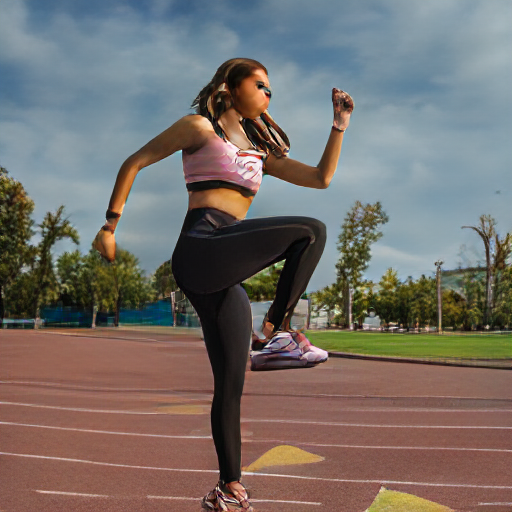

In [60]:
x = T.ToTensor()(img).unsqueeze(0).to(imagine.device).mul(2).sub(1)
vqgan = imagine.model.model.model
z, _, [_, _, indices] = vqgan.encode(x)
latents = z
print(latents.shape)
gen(imagine, latents)

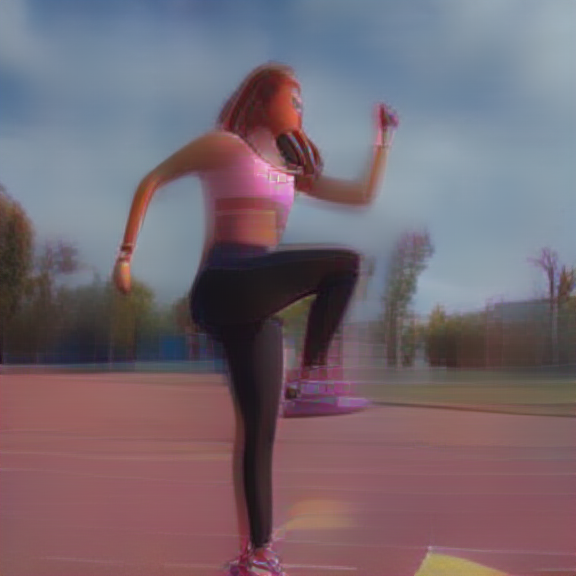

In [64]:
gen(imagine, interp)